Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

Modificacion: Se normalizaron los datos con MinMaxScale

In [6]:
#Veamos si la grafica esta disponible
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060 SUPER


In [7]:
# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [8]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1)

In [9]:
#Debemos convertir nuestros datos en una ventana de datos deslizantes.
import numpy as np

#Convertimos los datos a un array de 1 dimension
ShanghaiDat = np.array(ShanghaiDat).flatten()

#Aplicamos MinMaxScaler a los datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ShanghaiDat = scaler.fit_transform(ShanghaiDat.reshape(-1, 1)).flatten()


#Dividimos en epocas de n dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat) 
    sequences = [ShanghaiDat[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)

In [10]:
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, next_points):
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.next_points[idx]

In [11]:
#Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=12, num_layers=2, num_heads=4, dim_feedforward=512):
        super(TransformerModel, self).__init__() 
        self.sequence_length = sequence_length
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size*sequence_length, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(input_size * sequence_length, 1)

    def forward(self, src):
        src = src.reshape(-1, self.sequence_length, 1) 
        src = src.flatten(start_dim=1) 
        src = src.unsqueeze(0) 
        out = self.transformer_encoder(src) 
        out = out.squeeze(0) 
        return self.fc_out(out) 

In [12]:
# Preparamos los datos
sequences, next_points = Epocas()
dataset = TimeSeriesDataset(sequences, next_points) 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
#Entrenamiento del modelo
model = TransformerModel().to(device)
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

#Training loop
losses=[]
for epoch in range(300):
    for seq, next_point in dataloader:
        seq, next_point = seq.float().to(device), next_point.float().unsqueeze(1).to(device) 
        output = model(seq)
        loss = criterion(output, next_point) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.018947117030620575
Epoch 2, Loss: 0.0031131391879171133
Epoch 3, Loss: 0.0028951449785381556
Epoch 4, Loss: 0.004318167455494404
Epoch 5, Loss: 0.0038258926942944527
Epoch 6, Loss: 0.004620162770152092
Epoch 7, Loss: 0.0022417178843170404
Epoch 8, Loss: 0.004599927458912134
Epoch 9, Loss: 0.0011903448030352592
Epoch 10, Loss: 0.0023172730579972267
Epoch 11, Loss: 0.0022580570075660944
Epoch 12, Loss: 0.0009577622404322028
Epoch 13, Loss: 0.0016527498373761773
Epoch 14, Loss: 0.0014629464130848646
Epoch 15, Loss: 0.0023132264614105225
Epoch 16, Loss: 0.0023087284062057734
Epoch 17, Loss: 0.0009273235336877406
Epoch 18, Loss: 0.0006332415505312383
Epoch 19, Loss: 0.001867359154857695
Epoch 20, Loss: 0.0006417164695449173
Epoch 21, Loss: 0.0007743395399302244
Epoch 22, Loss: 0.0003462590975686908
Epoch 23, Loss: 0.001019088551402092
Epoch 24, Loss: 0.0007497548940591514
Epoch 25, Loss: 0.0009784245630726218
Epoch 26, Loss: 0.0007607027073390782
Epoch 27, Loss: 0.000656015

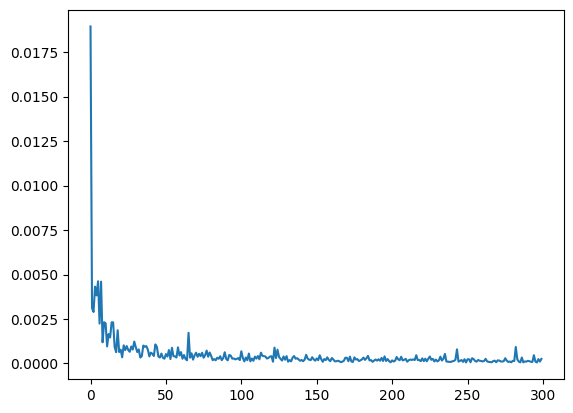

In [14]:
import matplotlib.pyplot as plt

losses = [loss.detach().cpu().item() for loss in losses]
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [20]:
# Veamos cómo predice el modelo

# Tomamos una secuencia ya escalada (por ejemplo, la primera del dataset)
test_seq = sequences[0].reshape(-1, 1)  # La convertimos a forma columna
test_seq = scaler.transform(test_seq).flatten()  # La reescalamos (aunque ya estaba escalada, es por claridad y generalidad)

# Convertimos a tensor y agregamos dimensión de batch
test_seq_tensor = torch.tensor(test_seq).float().unsqueeze(0).to(device)

# Obtenemos la predicción del modelo
with torch.no_grad():
    predicted_scaled = model(test_seq_tensor)

# Convertimos de vuelta a numpy
predicted_scaled_np = predicted_scaled.cpu().numpy()

# Desescalamos la predicción a su valor original
predicted_real = scaler.inverse_transform(predicted_scaled_np)

print("Predicción (dato siguiente real):", predicted_real.item())
print("Dato siguiente real original:", scaler.inverse_transform([[next_points[0]]])[0][0])


Predicción (dato siguiente real): 1216.1639404296875
Dato siguiente real original: 1204.39404296875


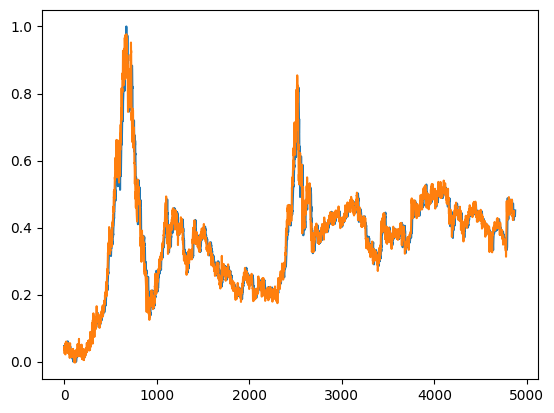

[0.026591002941131592, 0.039825499057769775, 0.035397499799728394, 0.045987024903297424, 0.033511996269226074, 0.0431087464094162, 0.040013641119003296, 0.046467699110507965, 0.026553183794021606, 0.036102645099163055, 0.05418670177459717, 0.03982246667146683, 0.02164161205291748, 0.044753506779670715, 0.04832123965024948, 0.035838186740875244, 0.051520757377147675, 0.04270882159471512, 0.05868463218212128, 0.05799100548028946, 0.048343852162361145, 0.06007145345211029, 0.056726180016994476, 0.057291820645332336, 0.04689812660217285, 0.054953545331954956, 0.049158088862895966, 0.05543528497219086, 0.05240876227617264, 0.05109191685914993, 0.053751781582832336, 0.055118754506111145, 0.04181275516748428, 0.04758258908987045, 0.032607585191726685, 0.04172244668006897, 0.046491965651512146, 0.054448679089546204, 0.043012090027332306, 0.025876812636852264, 0.049794651567935944, 0.02989201247692108, 0.030760325491428375, 0.03366818279027939, 0.0283341184258461, 0.04767324775457382, 0.0369300

In [16]:
#Comparemos los datos reales con las predicciones que hace el modelo con los mismos
predicciones=[]
for i in sequences:
    test_seq = torch.tensor(i).float()
    test_seq = test_seq.unsqueeze(0)
    test_seq = test_seq.to(device)
    with torch.no_grad():
        predicted_point = model(test_seq)
    predicciones.append(predicted_point.item())


plt.plot(ShanghaiDat)
plt.plot(predicciones)
plt.show()
print(predicciones)

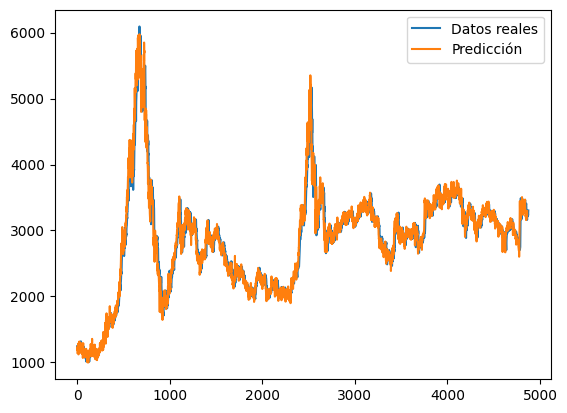

In [17]:
#Graficamos los datos desnormalizados
predicciones_array = np.array(predicciones).reshape(-1, 1)

predicciones_desnormalizadas = scaler.inverse_transform(predicciones_array)
ShanghaiDat_desnormalizado = scaler.inverse_transform(ShanghaiDat.reshape(-1, 1))

plt.plot(ShanghaiDat_desnormalizado, label='Datos reales')
plt.plot(predicciones_desnormalizadas, label='Predicción')
plt.legend()
plt.show()

In [19]:
print(ShanghaiDat_desnormalizado)
print(predicciones_desnormalizadas)

[[1242.77404785]
 [1251.93701172]
 [1239.43005371]
 ...
 [3229.48803711]
 [3270.65893555]
 [3303.66699219]]
[[1146.59615896]
 [1213.83478548]
 [1191.33807796]
 ...
 [3249.97797436]
 [3230.38611432]
 [3293.41547527]]
